In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rc('legend', fontsize=14)
plt.rcParams.update({'font.family': 'Times New Roman'})

In [3]:
data_dir = "filtered_data_sensitivity_analysis"

sca_files = [f for f in os.listdir(data_dir) if ".sca" in f]
vec_files = [f for f in os.listdir(data_dir) if ".vec" in f]

configuration_names = [file_name.split(",N=")[0] for file_name in sca_files]

dfs = {name: {"SCA": {}, "VEC": {},} for name in configuration_names}

for file_name in sca_files:
    print(file_name)
    df = pd.read_csv(f"{os.path.join(data_dir, file_name)}", dtype=str)
    
    if ".sca" in file_name:
        numNodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
        file_type = "SCA"
    elif ".vec" in file_name:
        numNodes = int(df.loc[df['attrname'] == "**.nrOfNodes"].attrvalue.iloc[0])
        file_type = "VEC"

    protocol = file_name.split(",N=")[0]
    
    try:
        dfs[protocol][file_type][numNodes].append(df)
    except KeyError:
        dfs[protocol][file_type][numNodes] = [df]

for protocol in dfs:
    node_counts = list(dfs[protocol]["SCA"].keys())
    node_counts.sort()
    
    dfs[protocol]["SCA"] = {node_count: dfs[protocol]["SCA"][node_count] for node_count in node_counts}
    # dfs[protocol]["VEC"] = {node_count: dfs[protocol]["VEC"][node_count] for node_count in node_counts}

pd.set_option('display.max_rows', None)   

df = None

MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.225,t=5,k=5,N=3000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.3,t=7,k=3,N=3000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.2,t=7,k=5,N=1000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.2,t=3,k=5,N=2000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.3,t=7,k=5,N=1000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=3,N=1000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.3,t=5,k=3,N=3000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1,N=5000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.15,t=3,k=1,N=1000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.175,t=3,k=1,N=3000-#0.sca.csv
MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.35,t=7,k=5,N=2000-

In [4]:
# Constants
p_rx = 25.74 / 1000 # W
p_tx = 389.4 / 1000 # W

def get_throughput_bytes_per_hour(df):
    # Throughput B / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    bytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * bytes_per_data_packet) / sim_time_hours

def get_throughput_kilobytes_per_hour(df):
    # Throughput kB / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    kilobytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8 / 1000
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * kilobytes_per_data_packet) / sim_time_hours

def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

def get_overhead_bytes(df):
    # Total bytes of overhead (Beacon, RTS, VCTS) or (ARS, FBP)
    possible_keys = [
        ('numARSPacketsSent', 'arsPacketLenBits'),
        ('numFBPPacketsSent', 'fbpPacketLenBits'),
        ('numRTSPacketsSent', 'rtsPacketLenBits'),
        ('numBeaconPacketsSent', 'beaconPacketLenBits'),
        ('numVCTSPacketsSent', 'vctsPacketLenBits'),
    ]
    
    overhead_bits = 0
    for key in possible_keys:
        try:
            total_num_packets = df.loc[df['name'] == key[0]].value.astype(int).sum()
            bits_per_packet = int(df.loc[df['name'] == key[1]].value.iloc[0])
            overhead_bits += (total_num_packets * bits_per_packet)
        except IndexError:
            pass

    return overhead_bits / 8

def get_data_bytes(df):
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return bits_per_data_packet * num_data_packets / 8

def get_avg_delay(df_sca):
    num_data_packets = int(df_sca.loc[df_sca['name'] == 'numDataPacketsReceived'].value.iloc[0])
    total_delay = float(df_sca.loc[df_sca['name'] == 'totalPacketDelay'].value.iloc[0])
    
    return total_delay / num_data_packets

def get_energy_satellite_DQ(df_sca):
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    
    # Sat always sends a FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_rounds * p_tx * t_fbp
    
    # Sat always listens for all contention slots
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    n_slots = int(df_sca.loc[df_sca['name'] == "numContentionSlots"].value.iloc[0])
    e_ars = num_rounds * p_rx * t_ars * n_slots
    
    # Sat only listens when a data packet will be sent len(dtq) != 0
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_rx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_node_DQ(df_sca):    
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    # Nodes always listen for FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_nodes * num_rounds * p_rx * t_fbp
    
    # Nodes only send ARS when the constraints are met
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    total_num_ars_packets_sent = df_sca.loc[df_sca['name'] == "numARSPacketsSent"].value.astype(int).sum()
    e_ars = total_num_ars_packets_sent * p_tx * t_ars
    
    # Only one or zero data packets can be sent each round
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_tx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_satellite_RESSIOT(df_sca):
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    w_rx = float(df_sca.loc[df_sca['name'] == "wrx"].value.iloc[0])
    e_rp_sat = num_rounds * ((p_tx * t_beacon) + (p_rx * w_rx))
    
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_sat = (num_rounds * p_tx * t_vcts) + (num_data_packets * p_rx * t_data)
    
    return e_rp_sat + e_tp_sat

def get_energy_node_RESSIOT(df_sca):
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    t_rts = float(df_sca.loc[df_sca['name'] == "rtsPacketTime"].value.iloc[0])
    total_num_rts_packets_sent = df_sca.loc[df_sca['name'] == "numRTSPacketsSent"].value.astype(int).sum()
    e_rp_nodes = (num_nodes * num_rounds * p_rx * t_beacon) + (total_num_rts_packets_sent * p_tx * t_rts)
    
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_nodes = (num_rounds * num_nodes * p_rx * t_vcts) + (num_data_packets * p_tx * t_data)

    return e_rp_nodes + e_tp_nodes

def get_avg_energy_efficiency_node(key, df_sca):
    if key == "RESS-IoT": 
        e_nodes = get_energy_node_RESSIOT(df_sca)
    elif "DQ" in key:
        e_nodes = get_energy_node_DQ(df_sca)

    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])
    
    return (get_data_bytes(df_sca) / num_nodes ) / (e_nodes / num_nodes)
    
def get_energy_efficiency_satellite(key, df_sca):
    if key == "RESS-IoT": 
        e_sat = get_energy_satellite_RESSIOT(df_sca)
    elif "DQ" in key:
        e_sat = get_energy_satellite_DQ(df_sca)
    
    return get_data_bytes(df_sca) / e_sat

def get_energy_efficiency_network(key, df_sca):
    if key == "RESS-IoT": 
        e_network = get_energy_satellite_RESSIOT(df_sca) + get_energy_node_RESSIOT(df_sca)
    elif "DQ" in key:
        e_network = get_energy_satellite_DQ(df_sca) + get_energy_node_DQ(df_sca)
    
    return get_data_bytes(df_sca) / e_network

In [5]:
metrics = {}

for protocol in dfs:
    print(f"Working on {protocol}...")
    
    metrics[protocol] = {}
    
    for node_count in dfs[protocol]["SCA"]:        
        metrics[protocol][node_count] = {
            "Average Delay [seconds]": [],
            "Jain Fairness Index": [],
            "Throughput [kilobytes / hour]": [],
            "Overhead": [],
            "Data": [],
            "Satellite Energy Efficiency [bytes / joule]": [],
            "Average Energy Efficiency per Node [bytes / joule]": [],
            "Network Energy Efficiency [bytes / joule]": [],
        }
        
        for df_sca in dfs[protocol]["SCA"][node_count]:            
            metrics[protocol][node_count]["Average Delay [seconds]"].append(get_avg_delay(df_sca))
            metrics[protocol][node_count]["Jain Fairness Index"].append(get_jfi(df_sca))
            metrics[protocol][node_count]["Throughput [kilobytes / hour]"].append(get_throughput_kilobytes_per_hour(df_sca))
            metrics[protocol][node_count]["Overhead"].append(get_overhead_bytes(df_sca))
            metrics[protocol][node_count]["Data"].append(get_data_bytes(df_sca))
            metrics[protocol][node_count]["Satellite Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_satellite(protocol, df_sca))
            metrics[protocol][node_count]["Average Energy Efficiency per Node [bytes / joule]"].append(get_avg_energy_efficiency_node(protocol, df_sca))
            metrics[protocol][node_count]["Network Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_network(protocol, df_sca))

Working on MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.225,t=5,k=5...
Working on MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.3,t=7,k=3...
Working on MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.2,t=7,k=5...
Working on MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.2,t=3,k=5...
Working on MSDQ_Sensitivity_Analysis-m=3,distribution=exponential,alpha=0.3,t=7,k=5...
Working on MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=3...
Working on MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.3,t=5,k=3...
Working on MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1...
Working on MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.15,t=3,k=1...
Working on MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.175,t=3,k=1...
Working on MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.35,t=7,k=5...
Working on MSDQ_Sensitivity_Analy

[(355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=5'),
 (355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=3'),
 (355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1'),
 (355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=5'),
 (355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=3'),
 (355.97460069743954,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1'),
 (350.2901631009162,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=1'),
 (350.1782685777132,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=5'),
 (350.1782685777132,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=3'),
 (340.9686622093487,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponenti

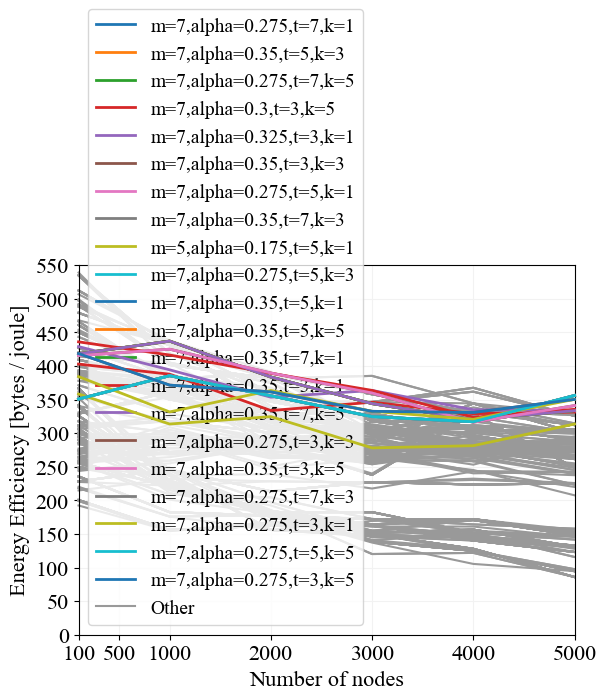

[(1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=5'),
 (1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=3'),
 (1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1'),
 (1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=5'),
 (1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=3'),
 (1.4405874727215102,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1'),
 (1.4161260491721654,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=1'),
 (1.414616748330489,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=5'),
 (1.414616748330489,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=3'),
 (1.3747424097901924,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponen

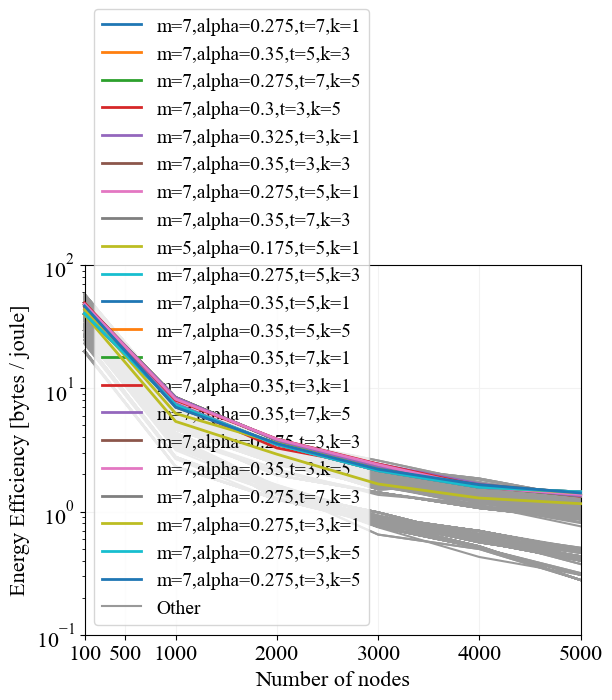

[(1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=5'),
 (1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=3'),
 (1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1'),
 (1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=5'),
 (1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=3'),
 (1.4347810819041897,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1'),
 (1.410424095442563,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=1'),
 (1.4089251071506586,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=5'),
 (1.4089251071506586,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=3,k=3'),
 (1.3692218807898504,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=expone

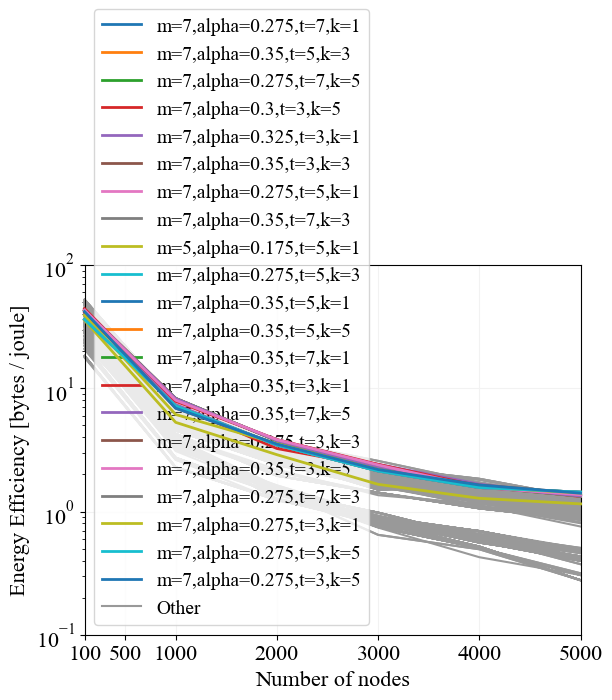

[(0.02911764705882353,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=3,k=1'),
 (0.028099415204678364,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=1,k=1'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=5'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=3'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=1'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=5,k=5'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=5,k=3'),
 (0.027283168316831682,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=5,k=1'),
 (0.027264150943396227,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=5'),
 (0.027264150943396227,
  'MSDQ_Sensitivity_Analysis-m=5

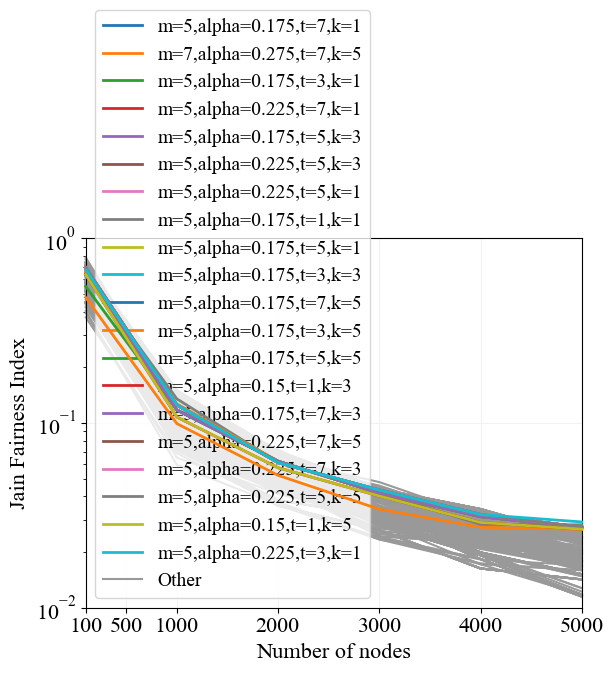

[(71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=5'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=3'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=1'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=5'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=3'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=1'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=5'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=3'),
 (71.4,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=1'),
 (69.72,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=5'),
 (69.72,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=3'),
 (69.72,
  'MSDQ_Se

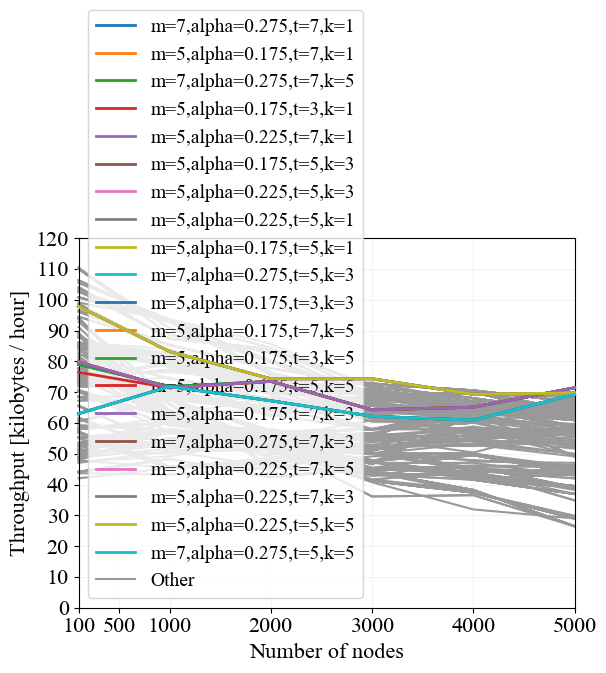

[(10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=5'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=3'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=7,k=1'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=5'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=3'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=1'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=5'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=3'),
 (10710.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=1'),
 (10458.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225,t=7,k=5'),
 (10458.0,
  'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.225

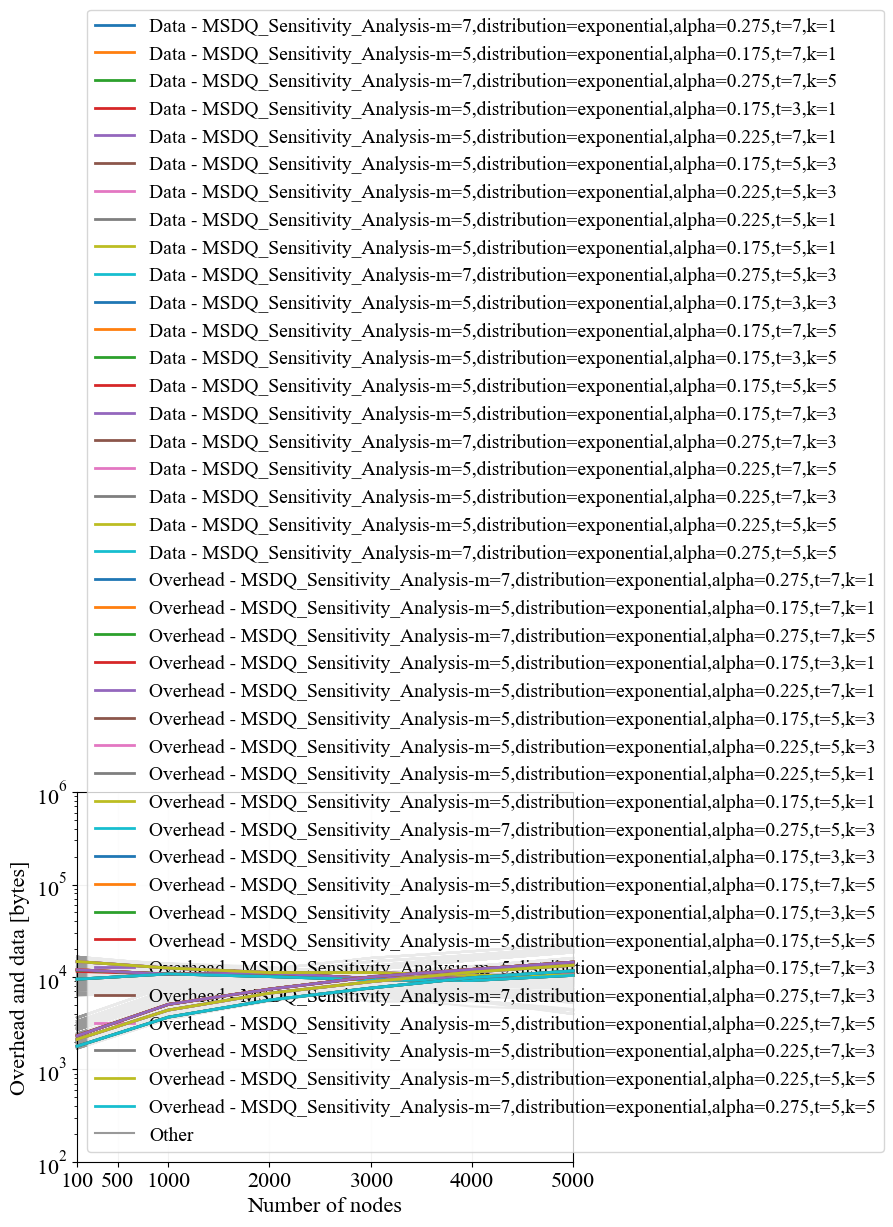

[(200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=3,k=1'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=3,k=3'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=3,k=5'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=5,k=1'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=5,k=3'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=5,k=5'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=7,k=1'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=7,k=3'),
 (200.47261379835513,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=7,k=5'),
 (204.77404081561608,
  'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,al

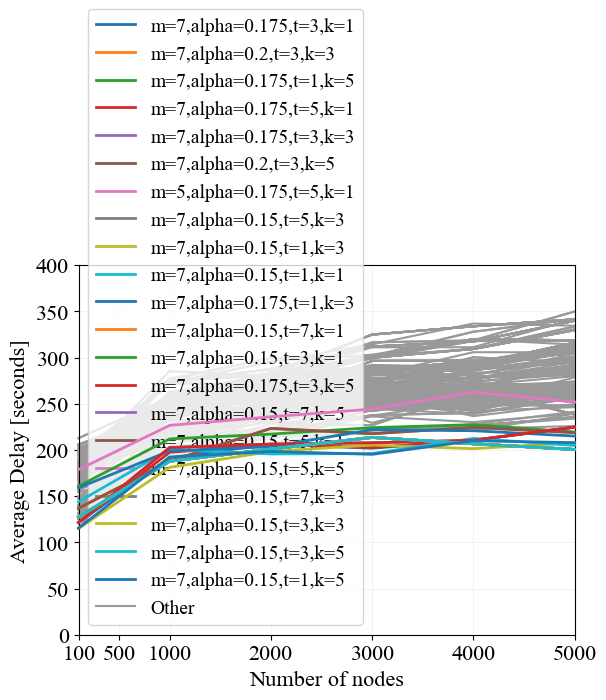

In [7]:
output_dir = "output_graphs/sensitivity_analysis"

def plot_runs(metric_names, label, ylims, is_log=False, show_metric_name=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)        

    values = []
    for protocol in metrics:
        # if "MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=1" in protocol or "MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=1" in protocol:
        values.append((metrics[protocol][5000][metric_names[0]][0], protocol))
                      
    values.sort(reverse=True)
    if metric_names[0] == "Average Delay [seconds]":
        values.sort()
    # pprint.pprint(values)
    values = values[:20]
    pprint.pprint(values)
    values = [value[1] for value in values]
    
    for metric in metric_names:
        for index, protocol in enumerate(metrics):            
            x = list(metrics[protocol].keys())[1:] # skip count = 10
            ys = [metrics[protocol][node_count][metric] for node_count in x]
            y = [np.average(y) for y in ys]

            key_label = protocol if not show_metric_name else f"{metric} - {protocol}"
                    
            if protocol in values or "MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=5,k=1" in protocol:
                # MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=7,k=1
                parts = protocol.split('-')[1].split(',')
                key_label = f"{parts[0]},{','.join(parts[2:])}" if not show_metric_name else f"{metric} - {protocol}"
                plt.plot(x, y, label=key_label, zorder=999, clip_on=False, linewidth=2)
            else:
                color = "#999999"
                zorder = 2
                if index == len(metrics) - 1 and metric == metric_names[-1]:
                    key_label = "Other"
                else:
                    key_label = "_nolegend_"

                plt.plot(x, y, label=key_label, color=color, zorder=zorder, clip_on=False)

    if "Energy Efficiency" in label:
        y_label = "Energy Efficiency [bytes / joule]"
    else:
        y_label = label
    plt.ylabel(y_label)
    plt.xlabel("Number of nodes")
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.legend(loc="lower left", ncol=1)
    plt.grid(linestyle='-', color='0.95')
    
    if is_log:
        plt.yscale("log")  
    
    plt.ylim(ylims[0], ylims[1])
    plt.xlim(100, 5000)
    
    x_ticks = np.append(ax.get_xticks()[1:], 100)
    x_ticks = np.append(x_ticks, 500)
    ax.set_xticks(x_ticks)

    if not is_log:
        ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 50))
        if len(ax.get_yticks()) < 5:
            ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 10))

    # plt.savefig(
    #     os.path.join(output_dir, f"sensitivity_analysis_{label.replace(' ', '_').replace('/', '_')}.pdf"),
    #     format="pdf",
    #     bbox_inches='tight'
    # )
    
    plt.show()

##### Satellite Energy Efficiency [bytes / joule]
metric = "Satellite Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0, 550], False)

##### Average Energy Efficiency per Node [bytes / joule]
metric = "Average Energy Efficiency per Node [bytes / joule]"
plot_runs([metric], metric, [0.1, 100], True)

##### Network Energy Efficiency [bytes / joule]
metric = "Network Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0.1, 100], True)

##### Jain Fairness Index
metric = "Jain Fairness Index"
plot_runs([metric], metric, [0.01, 1], True)

##### Throughput kilobytes / hour
metric = "Throughput [kilobytes / hour]"
plot_runs([metric], metric, [0, 120])

##### Overhead and data [bytes]
plot_runs(["Data", "Overhead"], "Overhead and data [bytes]", [100, 1000000], True, True)

##### Average Delay [seconds]
metric = "Average Delay [seconds]"
plot_runs([metric], metric, [0, 400])

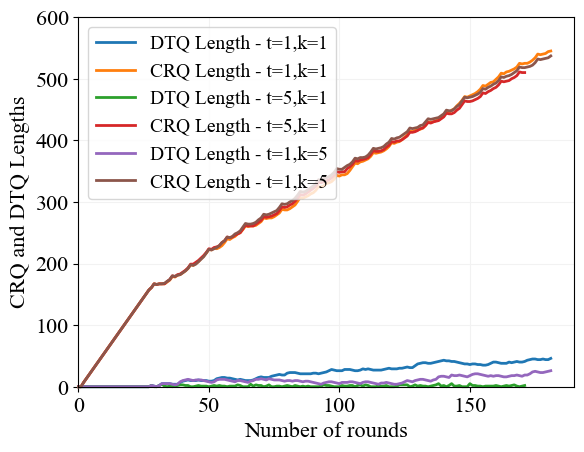

In [30]:
def get_queue_lengths(df):
    # CRQ and DTQ
    rounds = int(df.loc[df['name'] == "numFBPPacketsSent"].value.iloc[0])
    dtq_len = list(df[df['name'].str.startswith("dtqLength", na=False)].value.astype(int))[:rounds]
    crq_len = list(df[df['name'].str.startswith("crqLength", na=False)].value.astype(int))[:rounds]

    return (rounds, dtq_len, crq_len)

# values = []
# for protocol in dfs:
#     x, y_dtq, y_crq = get_queue_lengths(dfs[protocol]["SCA"][5000][0])
#     values.append((max(y_dtq), protocol))

# values.sort(reverse=True)
# pprint.pprint(values)

fig = plt.figure()
ax = fig.add_subplot(111)

protocols = [
    # 'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.15,t=1,k=1', # Only distribution change
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=1', # Largest DTQ
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1',
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=5',
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.225,t=1,k=5', # 2nd Largest DTQ
    # 'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=1', # Best throughput
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1', # Best energy efficiency
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=3,k=1', # Best delay
]
for protocol in protocols:            
    x, y_dtq, y_crq = get_queue_lengths(dfs[protocol]["SCA"][5000][0])
    x = [i for i in range(x)]

    parts = protocol.split('-')[1].split(',')
    key_label = f"{','.join(parts[3:])}"

    label_dtq = f"DTQ Length - {key_label}"
    label_crq = f"CRQ Length - {key_label}"

    p = plt.plot(x, y_dtq, label=label_dtq, clip_on=False, linewidth=2)
    color = p[-1].get_color()
    plt.plot(x, y_crq, label=label_crq, clip_on=False, linewidth=2)

label = "CRQ and DTQ Lengths"
plt.ylabel(label)
plt.xlabel("Number of rounds")
plt.legend(loc="upper left", ncol=1)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0, 600)
plt.xlim(0)

plt.savefig(
    os.path.join(output_dir, f"sensitivity_analysis_{label.replace(' ', '_').replace('/', '_')}.pdf"),
    format="pdf",
    bbox_inches='tight'
)
plt.show()

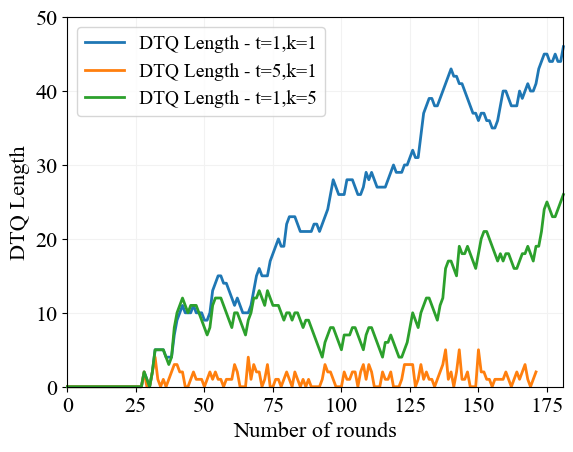

In [35]:
def get_queue_lengths(df):
    # CRQ and DTQ
    rounds = int(df.loc[df['name'] == "numFBPPacketsSent"].value.iloc[0])
    dtq_len = list(df[df['name'].str.startswith("dtqLength", na=False)].value.astype(int))[:rounds]
    crq_len = list(df[df['name'].str.startswith("crqLength", na=False)].value.astype(int))[:rounds]

    return (rounds, dtq_len, crq_len)

# values = []
# for protocol in dfs:
#     x, y_dtq, y_crq = get_queue_lengths(dfs[protocol]["SCA"][5000][0])
#     values.append((max(y_dtq), protocol))

# values.sort(reverse=True)
# pprint.pprint(values)

fig = plt.figure()
ax = fig.add_subplot(111)

protocols = [
    # 'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.15,t=1,k=1', # Only distribution change
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=1', # Largest DTQ
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1',
    'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=1,k=5',
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.225,t=1,k=5', # 2nd Largest DTQ
    # 'MSDQ_Sensitivity_Analysis-m=5,distribution=exponential,alpha=0.175,t=3,k=1', # Best throughput
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.275,t=5,k=1', # Best energy efficiency
    # 'MSDQ_Sensitivity_Analysis-m=7,distribution=exponential,alpha=0.15,t=3,k=1', # Best delay
]
for protocol in protocols:            
    x, y_dtq, y_crq = get_queue_lengths(dfs[protocol]["SCA"][5000][0])
    x = [i for i in range(x)]

    parts = protocol.split('-')[1].split(',')
    key_label = f"{','.join(parts[3:])}"

    label_dtq = f"DTQ Length - {key_label}"

    p = plt.plot(x, y_dtq, label=label_dtq, clip_on=False, linewidth=2)
    color = p[-1].get_color()

label = "DTQ Length"
plt.ylabel(label)
plt.xlabel("Number of rounds")
plt.legend(loc="upper left", ncol=1)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0, 50)
plt.xlim(0, max(x))

ax.set_xticks(np.arange(0, max(x), 25))

plt.savefig(
    os.path.join(output_dir, f"sensitivity_analysis_{label.replace(' ', '_').replace('/', '_')}.pdf"),
    format="pdf",
    bbox_inches='tight'
)
plt.show()